# Transforming

## Data cleaning

From data_exploration:

customers_df is structured, but lets inside the pipeline include a type check to ensure that correct data and data type is forwarded (for the fufture implementation)

Transactions_df is a bit unstructed and needs to be transformed.

    customer_id: rows with missing values -> should be removed. (As we cannot ensure which customer is related to the transaction, we must discard it)
    amount: seems to be a column with no missing values. Can be used as a good reference, but include a test in etl pipeline
    currency has: eur and EUR, values should be standardized to uppercase. Also lot of missing values and distribution graph indicates that these values could be DKK. For this project, I will proceed with imputing NaN -> DKK
    timestamp: ensure that dates are valid, no future dates
    category: There are two categories: food and electronics. These can be concatenated. Unknown values may be predicted using customer id, timestamp, currency and amount.


Transform

1. Remove duplicates from transactions
2. Handle missing values:
 - Drop transactions with missing customer_id (can't link to customers)
 - Impute or handle missing currency and category
3. Data type conversions (dates, proper numeric types)
4. Standardize values (currency codes to uppercase)
5. Filter invalid data (negative amounts, orphaned transactions)
6. Join datasets to create enriched transaction records


In [1]:
import pandas as pd

customers_df = pd.read_csv("../data/raw/csv/customers.csv")
transactions_df = pd.read_csv("../data/raw/csv/transactions.csv")

## Customers

In [2]:
EXPECTED_CUSTOMER_COLUMNS = {
    "customer_id": "int64",
    "country": "object",
    "signup_date": "object",
    "email": "object"
}

EXPECTED_TRANSACTION_COLUMNS = {
    "transaction_id": "int64",
    "customer_id": "float64",
    "amount": "float64",
    "currency": "object",
    "timestamp": "object",
    "category": "object"
}

def validate_schema(df, expected_cols):
    missing = set(expected_cols.keys()) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

validate_schema(customers_df, EXPECTED_CUSTOMER_COLUMNS)
validate_schema(transactions_df, EXPECTED_TRANSACTION_COLUMNS)

In [22]:
customers_clean = customers_df.copy()

customers_clean["customer_id"] = customers_clean["customer_id"].astype(int)
customers_clean["signup_date"] = pd.to_datetime(
    customers_clean["signup_date"], errors="coerce"
)

customers_clean = customers_clean.dropna(subset=["customer_id", "signup_date"])
customers_clean = customers_clean.drop_duplicates(subset=["customer_id"])

# Transactions

In [2]:
transactions_clean = transactions_df.copy()

In [3]:
transactions_clean = transactions_clean.drop_duplicates(subset=["transaction_id"])

In [5]:
transactions_clean = transactions_clean.dropna(subset=["customer_id"])
transactions_clean["customer_id"] = transactions_clean["customer_id"].astype('int64')

In [6]:
# No negative values
transactions_clean = transactions_clean[transactions_clean["amount"] >= 0]

In [25]:
transactions_clean["timestamp"] = pd.to_datetime(
    transactions_clean["timestamp"], errors="coerce"
)

now = pd.Timestamp.now()

transactions_clean = transactions_clean[
    (transactions_clean["timestamp"].notna()) &
    (transactions_clean["timestamp"] <= now)
]

In [9]:
transactions_clean["currency"] = (
    transactions_clean["currency"]
    .str.upper()
    .str.strip()
)

In [10]:
currency_by_customer = (
    transactions_clean
    .dropna(subset=["currency"])
    .groupby("customer_id")["currency"]
    .agg(lambda x: x.mode().iloc[0])
)

transactions_clean["currency"] = transactions_clean.apply(
    lambda row: currency_by_customer.get(row["customer_id"], row["currency"]),
    axis=1
)

In [11]:
transactions_clean["currency"] = transactions_clean["currency"].fillna("UNKNOWN")

In [12]:
import numpy as np

transactions_clean["category"] = (
    transactions_clean["category"]
    .str.lower()
    .str.strip()
)

transactions_clean["category"] = transactions_clean["category"].replace("unknown", np.nan)

In [13]:
category_by_customer = (
    transactions_clean
    .dropna(subset=["category"])
    .groupby("customer_id")["category"]
    .agg(lambda x: x.mode().iloc[0])
)

transactions_clean["category"] = transactions_clean.apply(
    lambda row: category_by_customer.get(row["customer_id"], row["category"]),
    axis=1
)

transactions_clean["category"] = transactions_clean["category"].fillna("unknown")


In [14]:
transactions_enriched = transactions_clean.merge(
    customers_clean,
    on="customer_id",
    how="inner"
)

In [24]:
transactions_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119219 entries, 0 to 119218
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   transaction_id  119219 non-null  int64         
 1   customer_id     119219 non-null  int64         
 2   amount          119219 non-null  float64       
 3   currency        119219 non-null  object        
 4   timestamp       119219 non-null  datetime64[ns]
 5   category        119219 non-null  object        
 6   country         119219 non-null  object        
 7   signup_date     119219 non-null  datetime64[ns]
 8   email           119219 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 8.2+ MB


In [20]:
transactions_enriched.describe(include="all")

,transaction_id,customer_id,amount,currency,timestamp,category,country,signup_date,email
count,119219.000000,119219.000000,119219.000000,119219,119219,119219,119219,119219,119219
unique,NaN,NaN,NaN,3,NaN,2,4,NaN,5000
top,NaN,NaN,NaN,EUR,NaN,electronics,SE,NaN,user3032@example.com
freq,NaN,NaN,NaN,103888,NaN,65450,30677,NaN,48
mean,59996.561052,2502.558795,100.799211,NaN,2020-06-22 11:18:44.493075712,NaN,NaN,2021-06-22 14:24:14.929164032,NaN
min,0.000000,1.000000,0.000000,NaN,2020-01-01 00:24:00,NaN,NaN,2019-01-01 00:00:00,NaN
25%,29989.500000,1253.000000,73.760000,NaN,2020-03-27 20:00:00,NaN,NaN,2020-03-25 00:00:00,NaN
50%,59998.000000,2509.000000,100.350000,NaN,2020-06-22 11:01:00,NaN,NaN,2021-07-01 00:00:00,NaN
75%,90005.500000,3753.000000,127.100000,NaN,2020-09-16 21:05:00,NaN,NaN,2022-09-18 12:00:00,NaN
max,119999.000000,5000.000000,263.110000,NaN,2020-12-13 05:18:00,NaN,NaN,2023-12-06 00:00:00,NaN


In [19]:
transactions_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119219 entries, 0 to 119218
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   transaction_id  119219 non-null  int64         
 1   customer_id     119219 non-null  int64         
 2   amount          119219 non-null  float64       
 3   currency        119219 non-null  object        
 4   timestamp       119219 non-null  datetime64[ns]
 5   category        119219 non-null  object        
 6   country         119219 non-null  object        
 7   signup_date     119219 non-null  datetime64[ns]
 8   email           119219 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 8.2+ MB


In [17]:
assert transactions_enriched["amount"].min() >= 0
assert transactions_enriched["customer_id"].isna().sum() == 0
assert transactions_enriched["transaction_id"].is_unique

# New Transaction cleaning

In [66]:
df = transactions_df.copy()

In [67]:
df = df.drop_duplicates()

In [68]:
df = df.dropna(subset=['customer_id'])

In [69]:
df['customer_id'] = df['customer_id'].astype('Int64')
df['transaction_id'] = df['transaction_id'].astype('Int64')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

In [75]:
len(df)

119970

In [76]:
invalid_amounts = (df['amount'] <= 0).sum()
df = df[df['amount'] > 0]

In [77]:
print(invalid_amounts)

753


In [78]:
len(df)

119217

The approach is to keep track of currency and category field with non value, but for now fill in with currency from own country and with 'unknown' category

In [79]:
df['is_category_imputed'] = df['category'].isna() | (df['category'].str.strip().str.lower() == 'unknown')
    
df['category'] = df['category'].fillna('uncategorized').str.lower()
df.loc[df['category'] == 'unknown', 'category'] = 'uncategorized'

In [80]:
print(df['is_category_imputed'].value_counts())

is_category_imputed
False    79538
True     39679
Name: count, dtype: int64


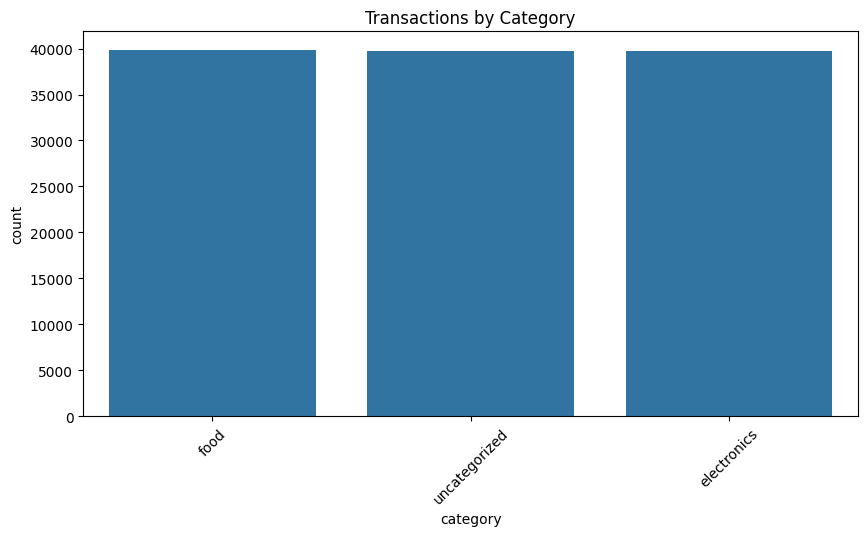

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x="category",
    order=df["category"].value_counts().index,
)
plt.title("Transactions by Category")
plt.xticks(rotation=45)
plt.show()

In [70]:
# Before uppercasing currency
currency_counts = df['currency'].value_counts(dropna=False)
print(currency_counts)

currency
NaN    24235
SEK    24057
NOK    23964
eur    23920
EUR    23794
Name: count, dtype: int64


In [71]:
df['currency'] = df['currency'].str.upper()

In [72]:
unique_currency = df['currency'].unique()
print(unique_currency)

['SEK' 'NOK' 'EUR' nan]


In [74]:
# Before uppercasing currency
currency_counts = df['currency'].value_counts(dropna=False)
print(currency_counts)

currency
EUR    47714
NaN    24235
SEK    24057
NOK    23964
Name: count, dtype: int64


In [82]:
df = df.merge(customers_df[['customer_id', 'country']], on='customer_id', how='left')

In [83]:
df['is_currency_imputed'] = df['currency'].isna()

df['currency'] = (
    df['currency']
    .fillna('DKK')
    .str.strip()
    .str.upper()
)

In [84]:
currency_counts = df['currency'].value_counts(dropna=False)
print(currency_counts)

currency
EUR    47390
DKK    24096
SEK    23919
NOK    23812
Name: count, dtype: int64


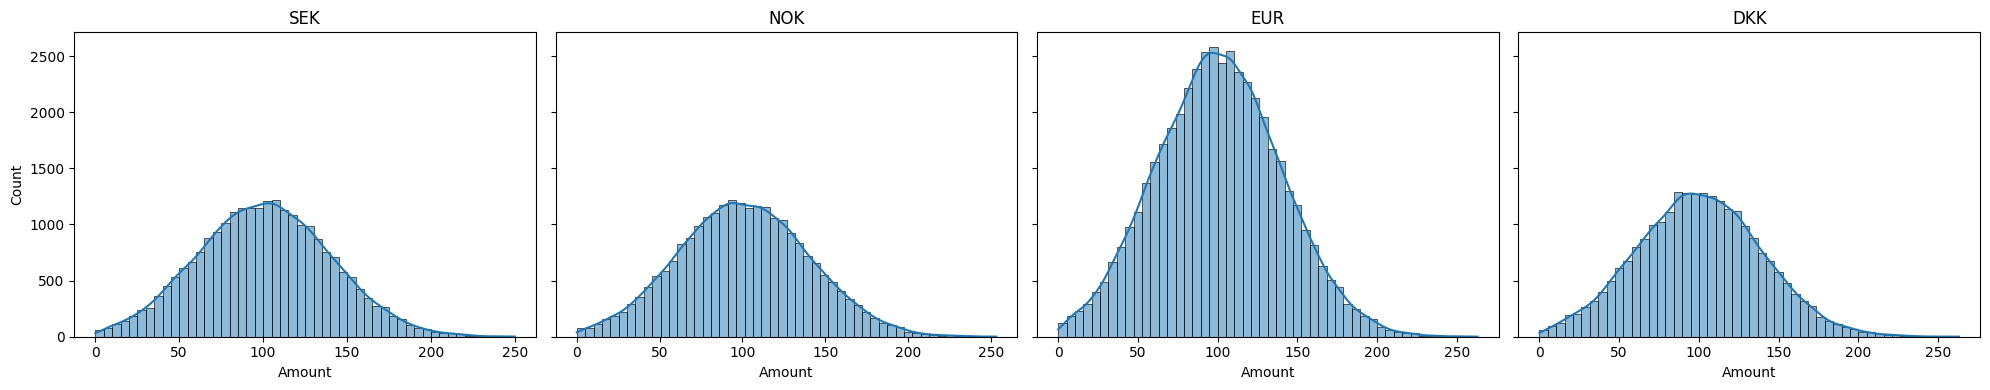

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

currencies = df["currency"].unique()

n = len(currencies)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(5 * cols, 4 * rows),
    sharey=True
)

axes = axes.flatten()

for ax, curr in zip(axes, currencies):

    if pd.isna(curr):
        data = df.loc[
            df["currency"].isna(), "amount"
        ]
        title = "NaN"
    else:
        data = df.loc[
            df["currency"] == curr, "amount"
        ]
        title = curr

    sns.histplot(
        data,
        bins=50,
        kde=True,
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel("Amount")
    ax.set_ylabel("Count")

# Remove empty plots
for ax in axes[len(currencies):]:
    ax.remove()

plt.tight_layout()

In [89]:
print(df['is_currency_imputed'].value_counts())

is_currency_imputed
False    95121
True     24096
Name: count, dtype: int64


# Final Check

In [106]:
import pandas as pd

customers_silver_df = pd.read_csv("../data/processed_silver/processed_customers.csv")
transactions_silver_df = pd.read_csv("../data/processed_silver/processed_transactions.csv")

In [111]:
transactions_silver_df.head(60)

,transaction_id,customer_id,amount,currency,timestamp,category,is_category_imputed,is_currency_imputed
0,107095,1,119.06,EUR,2020-01-07 14:13:00,uncategorized,True,False
1,37220,1,96.28,DKK,2020-01-30 19:32:00,uncategorized,True,True
2,57674,1,140.21,EUR,2020-02-12 08:32:00,electronics,False,False
3,103068,1,84.64,EUR,2020-02-22 15:16:00,uncategorized,True,False
4,53918,1,145.74,NOK,2020-02-23 12:02:00,food,False,False
5,53541,1,151.47,DKK,2020-02-24 03:38:00,uncategorized,True,True
6,86694,1,141.77,EUR,2020-03-09 03:38:00,uncategorized,True,False
7,12020,1,89.40,SEK,2020-03-16 10:55:00,food,False,False
8,105666,1,107.68,DKK,2020-04-10 10:22:00,electronics,False,True
9,20944,1,132.08,NOK,2020-04-14 21:48:00,electronics,False,False


In [98]:
print(customers_silver_df.columns)
print('=' * 50)
print(transactions_silver_df.columns)

Index(['customer_id', 'country', 'signup_date', 'email'], dtype='object')
Index(['transaction_id', 'customer_id', 'amount', 'currency', 'timestamp',
       'category', 'is_category_imputed', 'is_currency_imputed'],
      dtype='object')


In [97]:
print(customers_silver_df.info)
print('=' * 50)
print(transactions_silver_df.info)

<bound method DataFrame.info of       customer_id country signup_date                 email
0               1      DK  2022-01-22     user0@example.com
1               2      FI  2021-12-22     user1@example.com
2               3      SE  2023-08-18     user2@example.com
3               4      DK  2022-01-25     user3@example.com
4               5      DK  2019-09-26     user4@example.com
...           ...     ...         ...                   ...
4995         4996      SE  2021-07-20  user4995@example.com
4996         4997      NO  2021-12-16  user4996@example.com
4997         4998      DK  2020-08-13  user4997@example.com
4998         4999      NO  2020-03-18  user4998@example.com
4999         5000      FI  2021-09-09  user4999@example.com

[5000 rows x 4 columns]>
<bound method DataFrame.info of         transaction_id  customer_id  amount currency            timestamp  \
0                    0         1971  126.58      SEK  2020-04-29 06:17:00   
1                    1         3823 

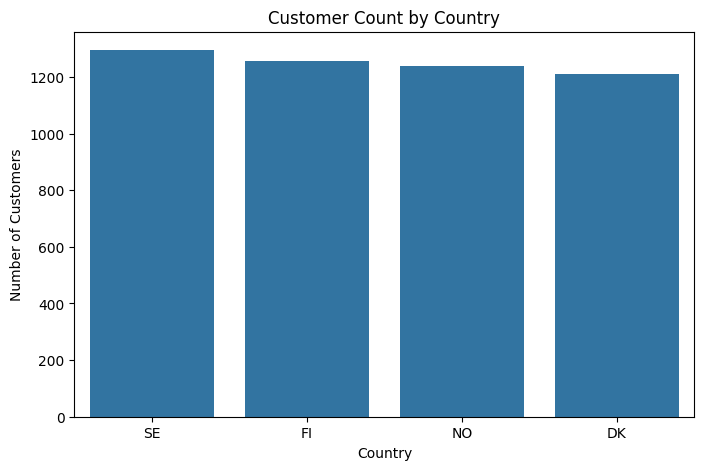

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Country distribution
plt.figure(figsize=(8, 5))
sns.countplot(
    data=customers_df, x="country", order=customers_df["country"].value_counts().index
)
plt.title("Customer Count by Country")
plt.xlabel("Country")
plt.ylabel("Number of Customers")
plt.show()

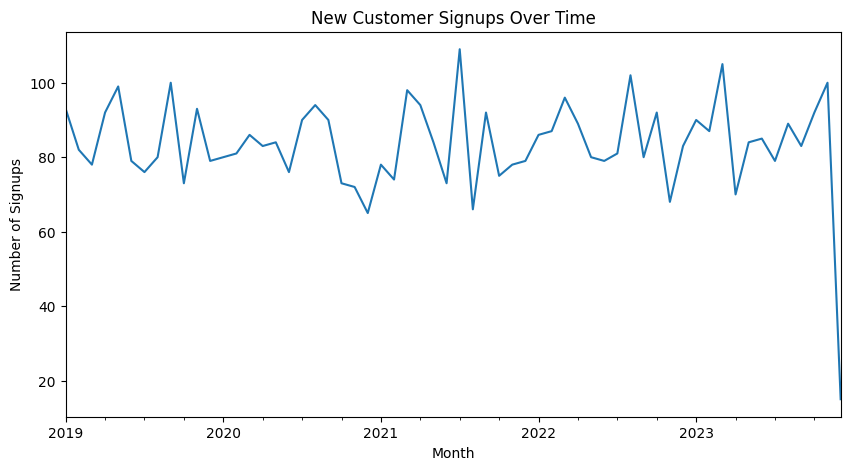

In [92]:
customers_silver_df["signup_date"] = pd.to_datetime(customers_silver_df["signup_date"])
signup_per_month = customers_df.groupby(
    customers_silver_df["signup_date"].dt.to_period("M")
).size()

signup_per_month.plot(kind="line", figsize=(10, 5))
plt.title("New Customer Signups Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Signups")
plt.show()

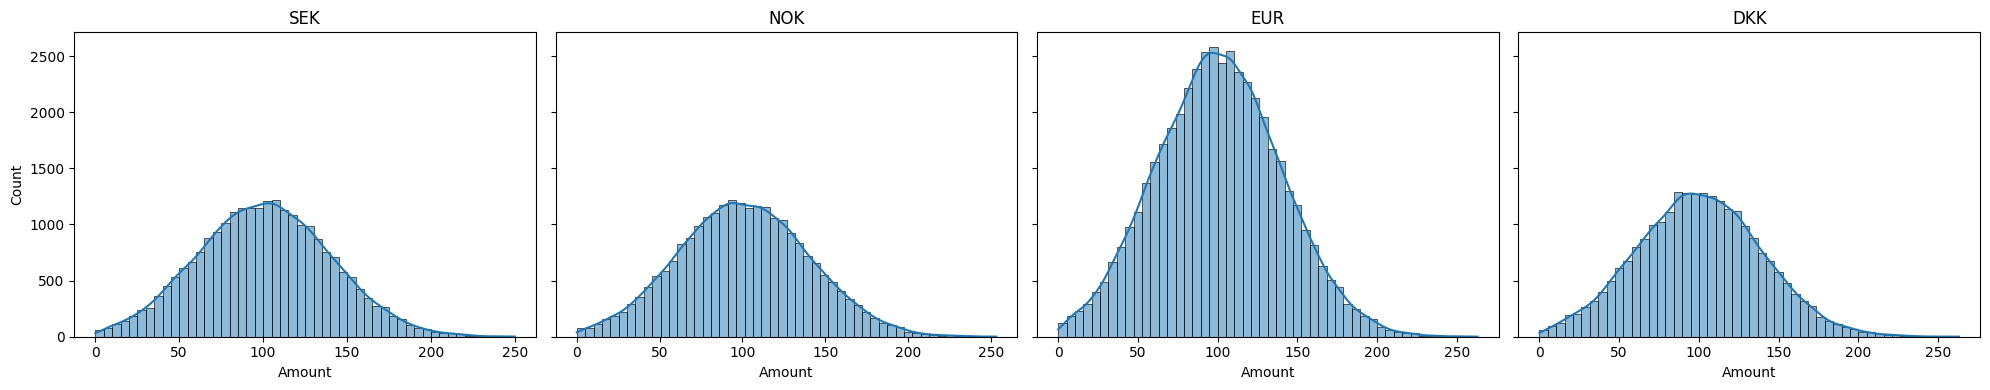

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

currencies = transactions_silver_df["currency"].unique()

n = len(currencies)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(5 * cols, 4 * rows),
    sharey=True
)

axes = axes.flatten()

for ax, curr in zip(axes, currencies):

    if pd.isna(curr):
        data = transactions_silver_df.loc[
            transactions_silver_df["currency"].isna(), "amount"
        ]
        title = "NaN"
    else:
        data = transactions_silver_df.loc[
            transactions_silver_df["currency"] == curr, "amount"
        ]
        title = curr

    sns.histplot(
        data,
        bins=50,
        kde=True,
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel("Amount")
    ax.set_ylabel("Count")

# Remove empty plots
for ax in axes[len(currencies):]:
    ax.remove()

plt.tight_layout()

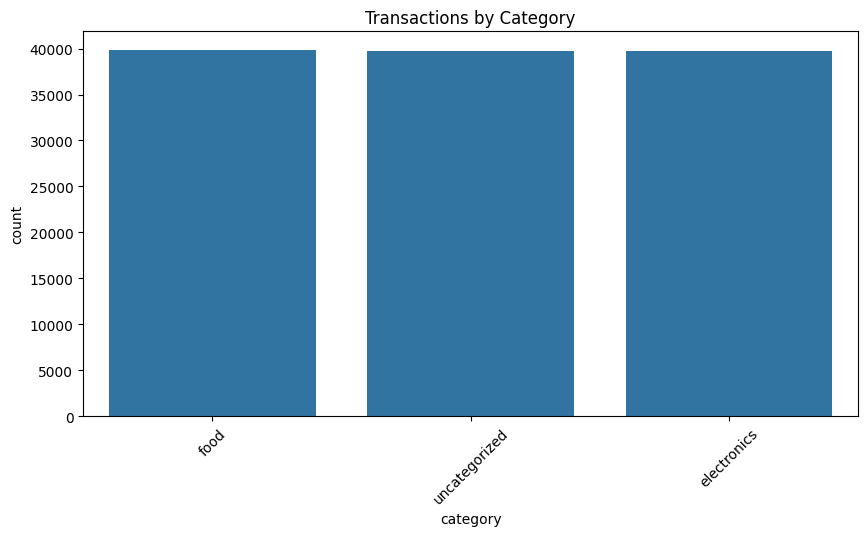

In [99]:
# Transactions per category
plt.figure(figsize=(10, 5))
sns.countplot(
    data=transactions_silver_df,
    x="category",
    order=transactions_silver_df["category"].value_counts().index,
)
plt.title("Transactions by Category")
plt.xticks(rotation=45)
plt.show()

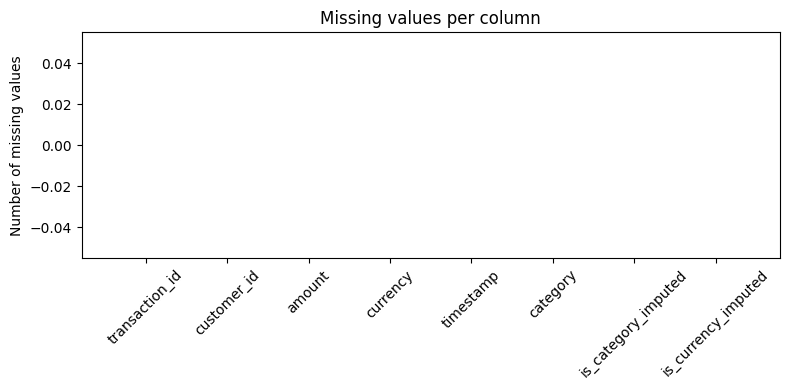

In [103]:
missing_counts = transactions_silver_df.isnull().sum()

plt.figure(figsize=(8, 4))
plt.bar(missing_counts.index, missing_counts.values)
plt.ylabel("Number of missing values")
plt.title("Missing values per column")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [104]:
def missing_summary(df):
    total = df.isna().sum()
    percent = (total / len(df)) * 100
    return pd.DataFrame({'missing_count': total, 'missing_percent': percent}).sort_values('missing_percent', ascending=False)

missing_summary(customers_silver_df)
missing_summary(transactions_silver_df)

,missing_count,missing_percent
transaction_id,0,0.0
customer_id,0,0.0
amount,0,0.0
currency,0,0.0
timestamp,0,0.0
category,0,0.0
is_category_imputed,0,0.0
is_currency_imputed,0,0.0
